In [68]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize']=10,6
import matplotlib.pyplot as plt

In [21]:
columns=['id',
'RI',
'Na',
'Mg', 
'Al',
'Si',
'K',
'Ca',
'Ba',
'Fe', # a derivate var which can be ignored 
'class'] 

Attribute Information:
1. Id number: 1 to 214
2. RI: refractive index
3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
4. Mg: Magnesium
5. Al: Aluminum
6. Si: Silicon
7. K: Potassium
8. Ca: Calcium
9. Ba: Barium
10. Fe: Iron
11. Type of glass: (class attribute)
  1. building_windows_float_processed
  2. building_windows_non_float_processed
  3. vehicle_windows_float_processed
  4. vehicle_windows_non_float_processed (none in this database)
  5. containers
  6. tableware
  7. headlamps

In [22]:
df=pd.read_csv('./glass.csv', names=columns)

In [24]:
df.head()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [25]:
import seaborn as sns

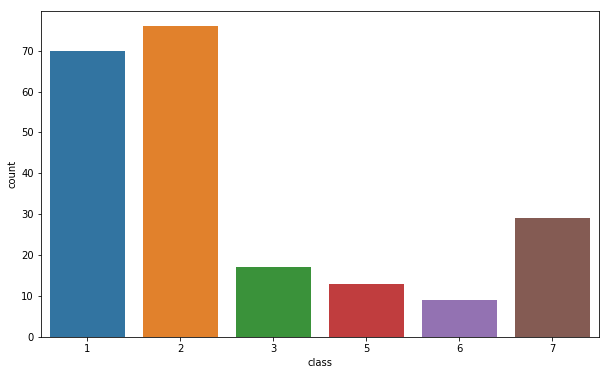

In [56]:
sns.countplot(x='class', data=df)

In [45]:
df_small=df.loc[df['class']<3]

In [47]:
df_small.head()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


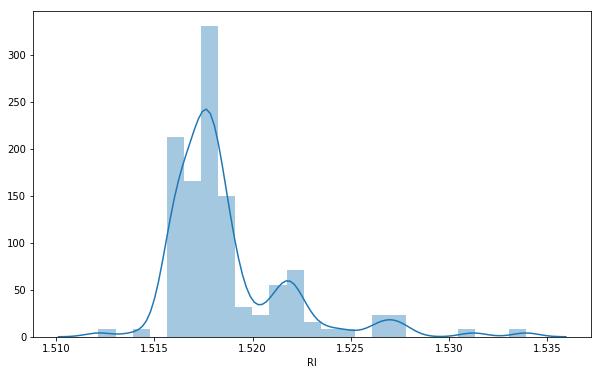

In [57]:
sns.distplot(df_small['RI'])

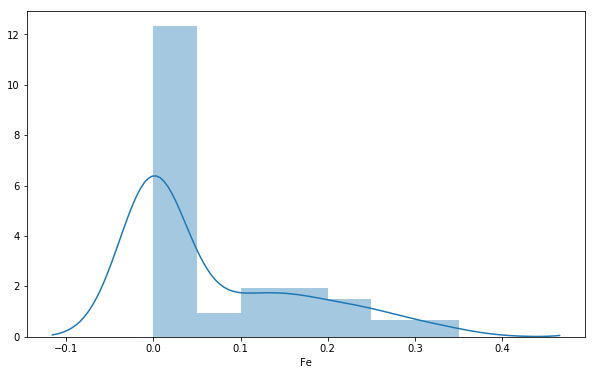

In [58]:
sns.distplot(df_small['Fe'])

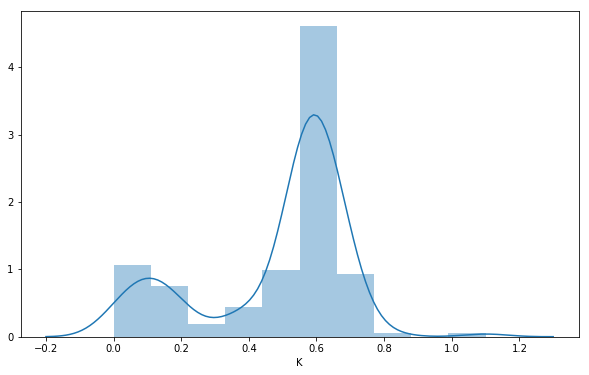

In [61]:
sns.distplot(df_small['K'], bins=10)

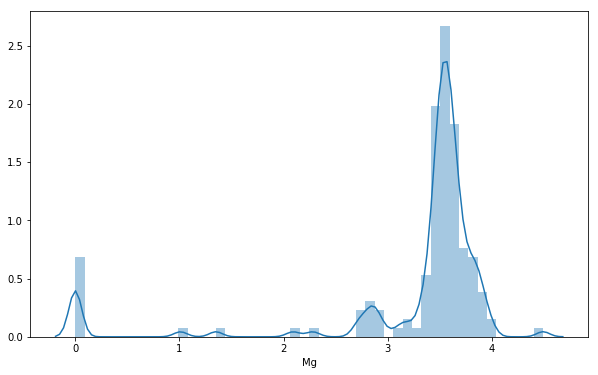

In [62]:
sns.distplot(df_small['Mg'])

In [271]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

In [97]:
x_train, x_test, y_train, y_test = train_test_split(df_small.drop(['id', 'class'], axis=1), df_small['class'], stratify=df_small['class'])

In [233]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [234]:
scaler=MinMaxScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

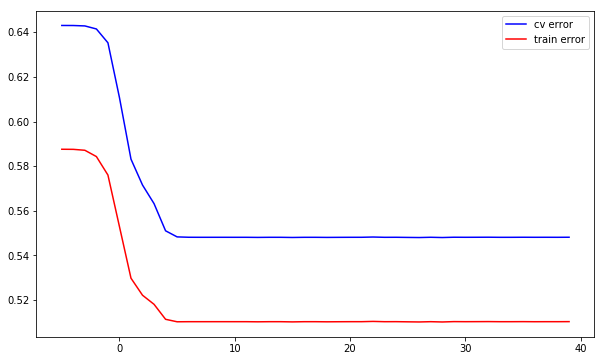

In [284]:
alpha=[10**x for x in np.arange(-5, 40, dtype=float)]
log_alpha=np.arange(-5,40)

cv_err=[]
train_err=[]
for a in alpha:
    clf=LogisticRegression(C=a, penalty='l2', class_weight='balanced')
    clf.fit(x_train, y_train)
    sig_clf=CalibratedClassifierCV(clf)
    sig_clf.fit(x_train, y_train)
    
    predict_y=sig_clf.predict_proba(x_test)
    cv_err.append(log_loss(y_test, predict_y))
    
    predict_y=sig_clf.predict_proba(x_train)
    train_err.append(log_loss(y_train, predict_y))

plt.plot(log_alpha, cv_err, label='cv error', c='b')
plt.plot(log_alpha, train_err, label='train error', c='r')
plt.legend()
plt.show()

In [285]:
alpha[np.argmin(cv_err)]

1e+26

In [286]:
np.min(cv_err)

0.5480284100512239

In [287]:
from sklearn.metrics import accuracy_score

In [293]:
accuracy_score(y_test, clf.predict(x_test))

0.7027027027027027

In [292]:
clf=LogisticRegression(C=alpha[np.argmin(cv_err)], penalty='l2', class_weight='balanced')
clf.fit(x_train, y_train)

LogisticRegression(C=1e+26, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [294]:
clf.coef_.T

array([[  2.2788908 ],
       [-21.10823284],
       [-30.39377841],
       [ -3.20900923],
       [-28.11562127],
       [ -4.10588636],
       [-53.55308351],
       [-24.22635827],
       [  1.02587204]])

In [295]:
np.array([columns[1:-1]]).T

array([['RI'],
       ['Na'],
       ['Mg'],
       ['Al'],
       ['Si'],
       ['K'],
       ['Ca'],
       ['Ba'],
       ['Fe']], dtype='<U2')

In [296]:
feature_importance=pd.DataFrame(np.hstack((np.array([columns[1:-1]]).T, clf.coef_.T)), columns=['feature', 'importance'])

In [306]:
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])

In [307]:
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
0,RI,2.278891
8,Fe,1.025872
3,Al,-3.209009
5,K,-4.105886
1,Na,-21.108233
7,Ba,-24.226358
4,Si,-28.115621
2,Mg,-30.393778
6,Ca,-53.553084


Si content, Ca content, Mg content are most valuable in determining whether glass is float processed or non float processed